<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/01_query_engine_router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RouterQueryEngine

There are many different techniques for LLM-based queries over your private data. To name a few:

- Summarization
- Top-k semantic search
- Complex queries such as compare and contrast

`RouterQueryEngine` is the one single interface which routes your queries to different query engines. It selects one out of several candidate query engines to execute a query.

LlamaIndex notebook: https://docs.llamaindex.ai/en/stable/examples/query_engine/RouterQueryEngine.html

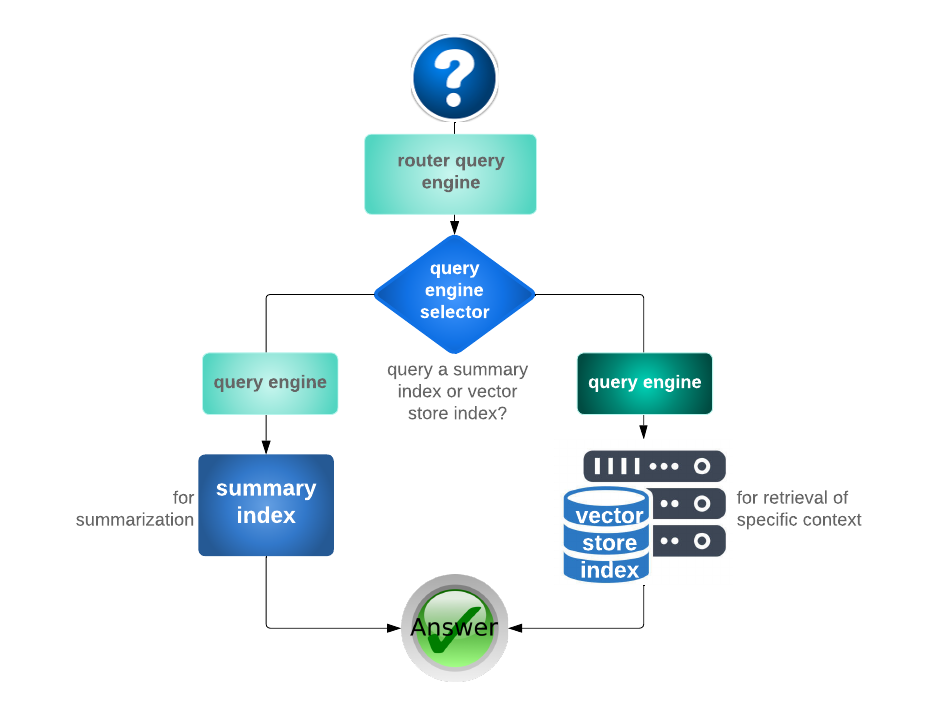

## Step 1: Install and Setup

In [1]:
!pip install -q llama_index pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.0/631.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [2]:
import logging, sys, os
import nest_asyncio
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# serves to enable nested asynchronous event loops, recommended for colab notebook
nest_asyncio.apply()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Step 2: Load data, build indices, define RouterQueryEngine

In [3]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, SummaryIndex
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors.llm_selectors import LLMSingleSelector

documents = SimpleDirectoryReader("data").load_data()
print(f"loaded {len(documents)} documents")

node_parser = SimpleNodeParser.from_defaults()
nodes = node_parser.get_nodes_from_documents(documents)

# construct summary_index and vector_index
summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)

# define summary_query_engine and vector_query_engine
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
vector_query_engine = summary_index.as_query_engine()

# build summary_tool and vector_tool
summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description="Useful for summarization questions on DevSecOps tooling.",
)
vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description="Useful for retrieving specific context on DevSecOps tooling.",
)

# define RouterQueryEngine
query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True,
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loaded 24 documents


## Step 3: Execute Queries

In [4]:
from IPython.display import Markdown

response = query_engine.query("Give me a summary of DevOps self-service-centric pipeline security and guardrails")
display(Markdown(f"<b>{response}</b>"))

Selecting query engine 0: Useful for summarization questions on DevSecOps tooling..


<b>DevOps self-service-centric pipeline security and guardrails involve implementing various tools and practices to ensure the security and compliance of the pipeline. These measures aim to enable developers to have ownership of DevOps pipelines while maintaining peace of mind regarding security. Key actions and tools for pipeline security and guardrails include Harden-Runner, Infracost, TFLint, Checkov, TFSec, Trivy, TruffleHog, and SonarScan. These tools help detect and prevent malicious patterns, provide cost breakdown and estimation for cloud resources, identify errors and enforce best practices in code, scan infrastructure as code for security and compliance issues, analyze container images for vulnerabilities, and analyze source code for security vulnerabilities and code quality issues. By implementing these security actions and guardrails, developers can work on the same application without being blocked by security issues, as other developers can focus on fixing vulnerabilities. Overall, these measures help ensure the security and quality of the pipeline and the applications developed within it.</b>

In [5]:
response = query_engine.query("Can TFLint be used to manage cloud costs? If not, which tool can manage cloud costs?")
display(Markdown(f"<b>{response}</b>"))

Selecting query engine 1: TFLint is not mentioned in the choices, so it cannot be used to manage cloud costs. Choice 2 is relevant as it suggests finding a tool for retrieving specific context on DevSecOps tooling, which could include a tool for managing cloud costs..


<b>No, TFLint cannot be used to manage cloud costs. It is a framework for linting Terraform code and enforcing best practices. The tool that can manage cloud costs is Infracost.</b>

In [6]:
response = query_engine.query("Compare and contrast Harden Runner and Infracost. When should each tool be used?")
display(Markdown(f"<b>{response}</b>"))

Selecting query engine 0: Useful for summarization questions on DevSecOps tooling..
Selecting query engine 1: Useful for retrieving specific context on DevSecOps tooling..


<b>Harden Runner and Infracost are two tools used in the context of DevOps self-service pipeline security and guardrails. 

Harden Runner is primarily used for enhancing pipeline security. It is a security monitoring agent that detects and prevents malicious patterns observed during past software supply chain security breaches. It automatically discovers and correlates outbound traffic with each step in the pipeline, prevents exfiltration of credentials, detects tampering of source code, and identifies compromised dependencies and build tools. Harden Runner is recommended for use in all pipelines to improve security.

In contrast, Infracost is primarily used for managing and controlling cloud costs. It provides a cost breakdown and estimation for cloud resources. It allows DevOps, SRE, and engineers to see a cost breakdown and understand costs before making changes in the terminal or pull requests. Infracost helps catch abnormal cloud cost estimates due to fat fingering or misconfiguration in Terraform configuration. It serves as a guardrail for cloud cost management by validating Terraform code changes against a predefined diff threshold. Infracost should be used when there is a need to monitor and control costs in the infrastructure code.

To summarize, Harden Runner is used for enhancing pipeline security, while Infracost is used for managing and controlling cloud costs. Harden Runner should be used in all pipelines to improve security, while Infracost should be used when there is a need to monitor and control costs in the infrastructure code.</b>